In [2]:
import math
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import statistics

In [3]:
wd_streme = Path("/home/ebelm/genomegraph/runs/20240903_replicate_STREME_results")
wd_model = Path("/home/ebelm/genomegraph/runs/20241008_model_on_STREME_data")
wd_model_init = Path("/home/ebelm/genomegraph/runs/20241010_model_on_STREME_data_untrained")
datadir = Path("/home/ebelm/genomegraph/data/STREME_benchmark_data")

In [4]:
ref_full = pd.read_csv(datadir / "full_ds_ref-motifs.tsv", sep="\t", names=["file", "motif"])
ref_hyb = pd.read_csv(datadir / "hybrid_ds_ref-motifs.tsv", sep="\t", names=["file", "motif"])

Accuracy

In [4]:
for wd, mdl in [(wd_streme, "streme"), (wd_model, "model"), (wd_model_init, "model_init")]:
    results_full = []
    for file in ref_full["file"]:
        p = wd / "full" / file
        assert p.exists(), f"{p} does not exist"
        assert (p / "tomtom").exists(), f"{p / 'tomtom'} does not exist"
        resultfile = p / "tomtom/tomtom.tsv"
        assert resultfile.exists(), f"{resultfile} does not exist"

        result = pd.read_csv(resultfile, sep="\t", comment="#")
        pval = result["p-value"].min()
        # negative log10 of p-value
        ppval = -math.log10(pval)
        results_full.append(ppval)

    ref_full[f"pp-value_{mdl}"] = results_full

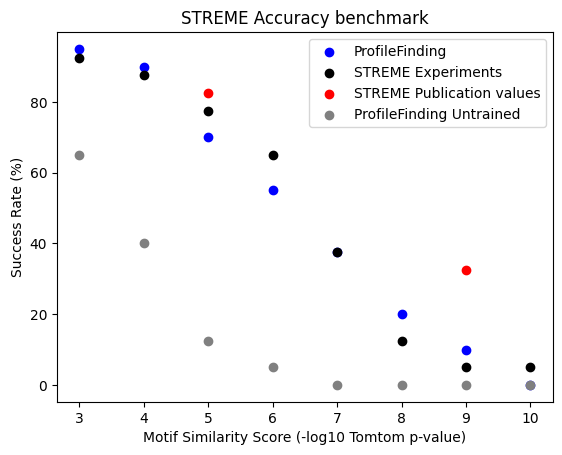

In [5]:
fig, ax = plt.subplots(1,1)
ax.scatter(x=range(3,11),
           y=[len(ref_full[ref_full["pp-value_model"] >= i].index)*100/len(ref_full.index) for i in range(3,11)],
           marker="o",
           color="blue")
ax.scatter(x=range(3,11),
           y=[len(ref_full[ref_full["pp-value_streme"] >= i].index)*100/len(ref_full.index) for i in range(3,11)],
           marker="o",
           color="black")
ax.scatter(x=[5, 9],
           y=[82.5, 32.5],
           marker="o",
           color="red")
ax.scatter(x=range(3,11),
           y=[len(ref_full[ref_full["pp-value_model_init"] >= i].index)*100/len(ref_full.index) for i in range(3,11)],
           marker="o",
           color="grey")
ax.set_xlabel("Motif Similarity Score (-log10 Tomtom p-value)")
ax.set_ylabel("Success Rate (%)")
ax.set_title("STREME Accuracy benchmark")
# add a legend in the plot
ax.legend(["ProfileFinding", "STREME Experiments", "STREME Publication values", "ProfileFinding Untrained"])
plt.show()

In [6]:
print(f"                   x: {range(3,11)[2]}")
print(f"STREME experiments y: {[len(ref_full[ref_full['pp-value_streme'] >= i].index)*100/len(ref_full.index) for i in range(3,11)][2]}")
print(f"ProfileFinding     y: {[len(ref_full[ref_full['pp-value_model'] >= i].index)*100/len(ref_full.index) for i in range(3,11)][2]}")

                   x: 5
STREME experiments y: 77.5
ProfileFinding     y: 70.0


Sensitivity

In [6]:
from Bio import SeqIO

# investigate (diluted) data: 
# - are the 3-mer frequencies really conserved? (they should be)
# - in diluted primary data, are really x% of sequences conserved?

def check_kmer_conservation(prim_fa: Path, ctrl_fa: Path, k: int = 3):
    def kmer_freqs(seq, k):
        kmers = {}
        for i in range(len(seq)-k+1):
            kmer = seq[i:i+k]
            if kmer not in kmers:
                kmers[kmer] = 0
            kmers[kmer] += 1
        return kmers

    prim = list(SeqIO.parse(prim_fa, "fasta"))
    ctrl = list(SeqIO.parse(ctrl_fa, "fasta"))

    kmer_freqs_prim = kmer_freqs(prim[0].seq, 3)
    kmer_freqs_ctrl = kmer_freqs(ctrl[0].seq, 3)

    diff1 = set(kmer_freqs_prim.keys()) - set(kmer_freqs_ctrl.keys())
    diff2 = set(kmer_freqs_ctrl.keys()) - set(kmer_freqs_prim.keys())
    diff3 = [(k, kmer_freqs_prim[k], kmer_freqs_ctrl[k]) for k in kmer_freqs_prim \
                if kmer_freqs_prim[k] != kmer_freqs_ctrl[k]]

    if len(diff1) > 0 or len(diff2) > 0 or len(diff3) > 0:
        print(f"Investigating {prim_fa} and {ctrl_fa}")
        print(f"\tKmers in primary data but not in control: {diff1}")
        print(f"\tKmers in control data but not in primary: {diff2}")
        print(f"\tDiffering kmer counts: {diff3}")

for file in ref_full["file"]:
    check_kmer_conservation(datadir / "full_ds_primary" / f"{file}.centered100bp.fasta", 
                            datadir / "full_ds_control" / f"{file}.centered100bp.fasta.shuf.fasta")

In [15]:
for purity in ["0.01", "0.02", "0.05", "0.10", "0.15", "0.20", "0.40", "0.60", "1.00"]:
    for file in ref_full["file"]:
        check_kmer_conservation(datadir / "diluted_ds_primary" / purity / f"{file}.centered100bp.{purity}pure.fasta", 
                                datadir / "diluted_ds_control" / purity / f"{file}.centered100bp.{purity}pure.shuf.fasta")


In [30]:
for file in ref_full["file"]:
    full = list(SeqIO.parse(datadir / "full_ds_primary" / f"{file}.centered100bp.fasta", "fasta"))
    full_set = set([s.seq for s in full])
    for purity in ["0.01", "0.02", "0.05", "0.10", "0.15", "0.20", "0.40", "0.60", "1.00"][::-1]:
        diluted = list(SeqIO.parse(datadir / "diluted_ds_primary" / purity / f"{file}.centered100bp.{purity}pure.fasta",
                                   "fasta"))
        print(f"{file} {purity} {len(diluted)*100/len(full)}")
        assert len(diluted) == len(full)
        purityf = float(purity)
        ndiluted = int(len(diluted) * (1-purityf))
        equal = sum([1 for i in range(len(diluted)) if diluted[i].seq in full_set])
        #assert [s.seq for s in diluted[ndiluted:]] == [s.seq for s in full[ndiluted:]], \
        assert equal == len(diluted) - ndiluted, \
            f"Sequences are not conserved in {file} {purity=} " \
                + f"| expected {ndiluted=}, observed {equal=} diluted={(len(diluted)-ndiluted)}"

wgEncodeAwgTfbsSydhK562Atf3UniPk.narrowPeak 1.00 100.0
wgEncodeAwgTfbsSydhK562Atf3UniPk.narrowPeak 0.60 100.0
wgEncodeAwgTfbsSydhK562Atf3UniPk.narrowPeak 0.40 100.0
wgEncodeAwgTfbsSydhK562Atf3UniPk.narrowPeak 0.20 100.0
wgEncodeAwgTfbsSydhK562Atf3UniPk.narrowPeak 0.15 100.0
wgEncodeAwgTfbsSydhK562Atf3UniPk.narrowPeak 0.10 100.0
wgEncodeAwgTfbsSydhK562Atf3UniPk.narrowPeak 0.05 100.0
wgEncodeAwgTfbsSydhK562Atf3UniPk.narrowPeak 0.02 100.0
wgEncodeAwgTfbsSydhK562Atf3UniPk.narrowPeak 0.01 100.0
wgEncodeAwgTfbsHaibK562Atf3V0416101UniPk.narrowPeak 1.00 100.0
wgEncodeAwgTfbsHaibK562Atf3V0416101UniPk.narrowPeak 0.60 100.0
wgEncodeAwgTfbsHaibK562Atf3V0416101UniPk.narrowPeak 0.40 100.0
wgEncodeAwgTfbsHaibK562Atf3V0416101UniPk.narrowPeak 0.20 100.0
wgEncodeAwgTfbsHaibK562Atf3V0416101UniPk.narrowPeak 0.15 100.0
wgEncodeAwgTfbsHaibK562Atf3V0416101UniPk.narrowPeak 0.10 100.0
wgEncodeAwgTfbsHaibK562Atf3V0416101UniPk.narrowPeak 0.05 100.0
wgEncodeAwgTfbsHaibK562Atf3V0416101UniPk.narrowPeak 0.02 100.0
w

In [8]:
import re 

# evaluate STREME sequence reordering runs (see if sequence order in input data matters)
wd_reorder = Path("/home/ebelm/genomegraph/runs/_trash/20241018_debug_STREME_diluted/full_reordered")
reorder_result = {
    'x': list(range(3,11))
}
for file in ref_full["file"]:
    repeats = sorted([d.name for d in (wd_reorder / file).iterdir() if d.is_dir() and re.match(r"\d+", d.name)])
    print(f"Processing {file}, {len(repeats)} repeats")
    reorder_result[file] = {
        'pp-value': [],
        'pp-value-same-ctrl': [],
    }
    for repeat in repeats:
        p = wd_reorder / file / repeat
        assert (p / "tomtom").exists(), f"{p / 'tomtom'} does not exist"
        resultfile = p / "tomtom/tomtom.tsv"
        assert resultfile.exists(), f"{resultfile} does not exist"

        result = pd.read_csv(resultfile, sep="\t", comment="#")
        pval = result["p-value"].min()
        # negative log10 of p-value
        ppval = -math.log10(pval)
        reorder_result[file]['pp-value'].append(ppval)

        assert (p / "original_control" / "tomtom").exists(), f"{p / 'original_control' / 'tomtom'} does not exist"
        resultfile = p / "original_control" / "tomtom/tomtom.tsv"
        assert resultfile.exists(), f"{resultfile} does not exist"

        result = pd.read_csv(resultfile, sep="\t", comment="#")
        pval = result["p-value"].min()
        # negative log10 of p-value
        ppval = -math.log10(pval)
        reorder_result[file]['pp-value-same-ctrl'].append(ppval)

Processing wgEncodeAwgTfbsSydhK562Atf3UniPk.narrowPeak, 20 repeats
Processing wgEncodeAwgTfbsHaibK562Atf3V0416101UniPk.narrowPeak, 20 repeats
Processing wgEncodeAwgTfbsSydhK562Atf106325UniPk.narrowPeak, 20 repeats
Processing wgEncodeAwgTfbsSydhK562Bhlhe40nb100IggrabUniPk.narrowPeak, 20 repeats
Processing wgEncodeAwgTfbsSydhK562CebpbIggrabUniPk.narrowPeak, 20 repeats
Processing wgEncodeAwgTfbsBroadK562CtcfUniPk.narrowPeak, 20 repeats
Processing wgEncodeAwgTfbsUwK562CtcfUniPk.narrowPeak, 20 repeats
Processing wgEncodeAwgTfbsUtaK562CtcfUniPk.narrowPeak, 20 repeats
Processing wgEncodeAwgTfbsSydhK562E2f4UcdUniPk.narrowPeak, 20 repeats
Processing wgEncodeAwgTfbsSydhK562E2f6UcdUniPk.narrowPeak, 20 repeats
Processing wgEncodeAwgTfbsHaibK562E2f6V0416102UniPk.narrowPeak, 20 repeats
Processing wgEncodeAwgTfbsHaibK562Egr1V0416101UniPk.narrowPeak, 20 repeats
Processing wgEncodeAwgTfbsHaibK562Elf1sc631V0416102UniPk.narrowPeak, 20 repeats
Processing wgEncodeAwgTfbsSydhK562Elk112771IggrabUniPk.narrowP

In [9]:
reorder_result

{'x': [3, 4, 5, 6, 7, 8, 9, 10],
 'wgEncodeAwgTfbsSydhK562Atf3UniPk.narrowPeak': {'pp-value': [2.5188197474052894,
   nan,
   nan,
   nan,
   nan,
   nan,
   4.066802338358697,
   nan,
   nan,
   nan,
   1.011665382495725,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan],
  'pp-value-same-ctrl': [nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan]},
 'wgEncodeAwgTfbsHaibK562Atf3V0416101UniPk.narrowPeak': {'pp-value': [8.103279826261877,
   7.785285930058005,
   8.031597380004513,
   7.835450863674223,
   7.969979453534187,
   7.96995513693385,
   7.4079265525553355,
   7.5223998378506804,
   8.007412022731762,
   8.03086143500262,
   7.394475168106899,
   7.789638668287009,
   7.8228676829582255,
   8.014173099737862,
   7.949025092055548,
   7.929267817525891,
   7.892654334527905,
   7.88817313589365,
   7.838075259778379,
   8.12463715144666],
  'pp-value-s

Order of (primary) input sequences does _not_ matter, but the background/control sequences have a great impact on the
result. The tomtom p-value can differ in over one order of magnitude for the same motif depending on the background,
STREME can also sometimes find no motif at all for the same input sequences depending on the background.

In [7]:
from Bio import SeqIO
# investigate why diluted with 1.00 purity is different from full dataset runs
for file in ref_full["file"]:
    full_fasta = datadir / "full_ds_primary" / f"{file}.centered100bp.fasta"
    diluted_fasta = datadir / "diluted_ds_primary" / "1.00" / f"{file}.centered100bp.1.00pure.fasta"

    # parse both fastas and check if they are the same with BioPython
    full = list(SeqIO.parse(full_fasta, "fasta"))
    diluted = list(SeqIO.parse(diluted_fasta, "fasta"))
    assert len(full) == len(diluted), f"{file} has different number of sequences"
    for f, d in zip(full, diluted):
        assert f.seq == d.seq, f"{file} has different primary sequences"

    # do the same for the control seqs, they should probably be the different
    full_control = datadir / "full_ds_control" / f"{file}.centered100bp.fasta.shuf.fasta"
    diluted_control = datadir / "diluted_ds_control" / "1.00" / f"{file}.centered100bp.1.00pure.shuf.fasta"
    full = list(SeqIO.parse(full_control, "fasta"))
    diluted = list(SeqIO.parse(diluted_control, "fasta"))
    assert len(full) == len(diluted), f"{file} has different number of control sequences"
    for f, d in zip(full, diluted):
        assert f.seq != d.seq, f"{file} has the same control sequences"


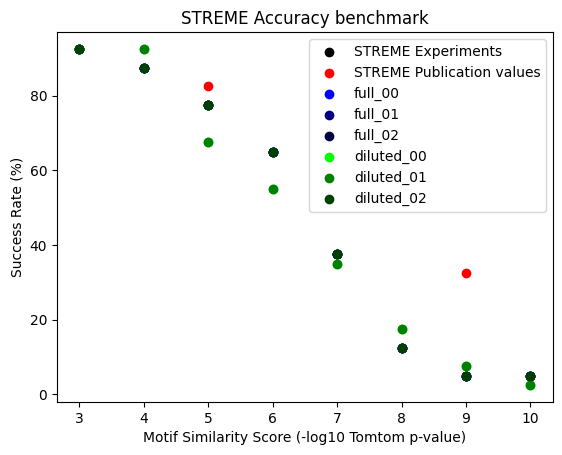

In [8]:
# make accuracy plots of debug runs
wd_dbg = Path("/home/ebelm/genomegraph/runs/_trash/20241018_debug_STREME_diluted")
dbg_result = {}
for wd, run in [
    (wd_dbg / 'full' / '00', "full_00"), 
    (wd_dbg / 'full' / '01', "full_01"), 
    (wd_dbg / 'full_same_ctrl', "full_02"), 
    (wd_dbg / 'diluted1.00' / '00', "diluted_00"), 
    (wd_dbg / 'diluted1.00' / '01', "diluted_01"), 
    (wd_dbg / 'diluted_same_ctrl', "diluted_02")]:
    results_full = []
    for file in ref_full["file"]:
        p = wd / file
        assert p.exists(), f"{p} does not exist"
        assert (p / "tomtom").exists(), f"{p / 'tomtom'} does not exist"
        resultfile = p / "tomtom/tomtom.tsv"
        assert resultfile.exists(), f"{resultfile} does not exist"

        result = pd.read_csv(resultfile, sep="\t", comment="#")
        pval = result["p-value"].min()
        # negative log10 of p-value
        ppval = -math.log10(pval)
        results_full.append(ppval)

    dbg_result[run] = results_full

# ----

fig, ax = plt.subplots(1,1)
ax.scatter(x=range(3,11),
           y=[len(ref_full[ref_full["pp-value_streme"] >= i].index)*100/len(ref_full.index) for i in range(3,11)],
           marker="o",
           color="black")
ax.scatter(x=[5, 9],
           y=[82.5, 32.5],
           marker="o",
           color="red")
ax.scatter(x=range(3,11),
           y=[sum([1 for r in dbg_result['full_00'] if r >= i])*100/len(dbg_result['full_00']) for i in range(3,11)],
           marker="o",
           color=(0.0, 0.0, 1))
ax.scatter(x=range(3,11),
           y=[sum([1 for r in dbg_result['full_01'] if r >= i])*100/len(dbg_result['full_01']) for i in range(3,11)],
           marker="o",
           color=(0.0, 0.0, 0.5))
ax.scatter(x=range(3,11),
           y=[sum([1 for r in dbg_result['full_02'] if r >= i])*100/len(dbg_result['full_02']) for i in range(3,11)],
           marker="o",
           color=(0.0, 0.0, 0.25))
ax.scatter(x=range(3,11),
           y=[sum([1 for r in dbg_result['diluted_00'] if r >= i])*100/len(dbg_result['diluted_00']) for i in range(3,11)],
           marker="o",
           color=(0.0, 1.0, 0.0))
ax.scatter(x=range(3,11),
           y=[sum([1 for r in dbg_result['diluted_01'] if r >= i])*100/len(dbg_result['diluted_01']) for i in range(3,11)],
           marker="o",
           color=(0.0, 0.5, 0.0))
ax.scatter(x=range(3,11),
           y=[sum([1 for r in dbg_result['diluted_02'] if r >= i])*100/len(dbg_result['diluted_02']) for i in range(3,11)],
           marker="o",
           color=(0.0, 0.25, 0.0))
ax.set_xlabel("Motif Similarity Score (-log10 Tomtom p-value)")
ax.set_ylabel("Success Rate (%)")
ax.set_title("STREME Accuracy benchmark")
# add a legend in the plot
ax.legend(["STREME Experiments", "STREME Publication values", 
           "full_00", "full_01", "full_02", 
           "diluted_00", "diluted_01", "diluted_02"])
plt.show()

In [9]:
# make accuracy plots of debug ProfileFinding runs
wd_dbg = Path("/home/ebelm/genomegraph/runs/_trash/20241022_debug_ProfileFinding_diluted/apphub")
dbg_result = {}
for wd, run in [
    (wd_dbg / 'full' / '00', "full_00"), 
    (wd_dbg / 'full' / '01', "full_01"), 
    (wd_dbg / 'diluted1.00' / '00', "diluted_00"), 
    (wd_dbg / 'diluted1.00' / '01', "diluted_01")]:
    results_full = []
    for file in ref_full["file"]:
        p = wd / file
        assert p.exists(), f"{p} does not exist"
        assert (p / "tomtom").exists(), f"{p / 'tomtom'} does not exist"
        resultfile = p / "tomtom/tomtom.tsv"
        assert resultfile.exists(), f"{resultfile} does not exist"

        result = pd.read_csv(resultfile, sep="\t", comment="#")
        pval = result["p-value"].min()
        # negative log10 of p-value
        ppval = -math.log10(pval)
        results_full.append(ppval)

    dbg_result[run] = results_full

# ----

fig, ax = plt.subplots(1,1)
ax.scatter(x=range(3,11),
           y=[len(ref_full[ref_full["pp-value_model"] >= i].index)*100/len(ref_full.index) for i in range(3,11)],
           marker="o",
           color="blue")
ax.scatter(x=[5, 9],
           y=[82.5, 32.5],
           marker="o",
           color="red")
ax.scatter(x=range(3,11),
           y=[sum([1 for r in dbg_result['full_00'] if r >= i])*100/len(dbg_result['full_00']) for i in range(3,11)],
           marker="o",
           color=(0.0, 0.0, 1))
ax.scatter(x=range(3,11),
           y=[sum([1 for r in dbg_result['full_01'] if r >= i])*100/len(dbg_result['full_01']) for i in range(3,11)],
           marker="o",
           color=(0.0, 0.0, 0.5))
ax.scatter(x=range(3,11),
           y=[sum([1 for r in dbg_result['diluted_00'] if r >= i])*100/len(dbg_result['diluted_00']) for i in range(3,11)],
           marker="o",
           color=(0.0, 1.0, 0.0))
ax.scatter(x=range(3,11),
           y=[sum([1 for r in dbg_result['diluted_01'] if r >= i])*100/len(dbg_result['diluted_01']) for i in range(3,11)],
           marker="o",
           color=(0.0, 0.5, 0.0))

ax.set_xlabel("Motif Similarity Score (-log10 Tomtom p-value)")
ax.set_ylabel("Success Rate (%)")
ax.set_title("ProfileFinding Accuracy benchmark")
# add a legend in the plot
ax.legend(["ProfileFinding Experiments", "STREME Publication values", 
           "full_00", "full_01", 
           "diluted_00", "diluted_01"])
plt.show()

AssertionError: /home/ebelm/genomegraph/runs/_trash/20241022_debug_ProfileFinding_diluted/apphub/full/00/wgEncodeAwgTfbsSydhK562Atf3UniPk.narrowPeak does not exist

In [5]:
results_diluted = {
    'streme': {
        'purity': [],
        'success_rate': []
    },
    'model': {
        'purity': [],
        'success_rate': []
    },
    'model_init': {
        'purity': [],
        'success_rate': []
    }
}

for wd, mdl in [(wd_streme, "streme"), (wd_model, "model"), (wd_model_init, "model_init")]:
    purities = sorted([d.name for d in (wd / 'diluted').iterdir() if d.is_dir() and d.name != "logs"])
    print(f"{purities=}")
    for purity in purities:
        results_diluted[mdl]['purity'].append(int(float(purity)*100))
        ny = 0
        for file in ref_full["file"]:
            p = wd / "diluted" / purity / file
            assert p.exists(), f"{p} does not exist"
            if not (p / "tomtom").exists():
                print(f"[WARNING] >>> {p / 'tomtom'} does not exist")
                continue

            resultfile = p / "tomtom/tomtom.tsv"
            assert resultfile.exists(), f"{resultfile} does not exist"

            #print(f"[DEBUG] >>> [{mdl=}] {resultfile}")
            result = pd.read_csv(resultfile, sep="\t", comment="#")
            pval = result["p-value"].min()
            # negative log10 of p-value
            ppval = -math.log10(pval)
            if ppval >= 5:
                ny += 1

        results_diluted[mdl]['success_rate'].append(ny*100/len(ref_full.index))

purities=['0.01', '0.02', '0.05', '0.10', '0.15', '0.20', '0.40', '0.60', '1.00']
purities=['0.01', '0.02', '0.05', '0.10', '0.15', '0.20', '0.40', '0.60', '1.00']
purities=['0.01', '0.02', '0.05', '0.10', '0.15', '0.20', '0.40', '0.60', '1.00']


In [6]:
# also add ProfileFinding results with finer dilution steps

purities = sorted([d.name for d in (wd_model / 'diluted_custom').iterdir() if d.is_dir() and d.name != "logs"])
print(f"{purities=}")
for purity in purities:
    results_diluted["model"]['purity'].append(int(float(purity)*100))
    ny = 0
    for file in ref_full["file"]:
        p = wd_model / "diluted_custom" / purity / file
        assert p.exists(), f"{p} does not exist"
        if not (p / "tomtom").exists():
            print(f"[WARNING] >>> {p / 'tomtom'} does not exist")
            continue

        resultfile = p / "tomtom/tomtom.tsv"
        assert resultfile.exists(), f"{resultfile} does not exist"

        #print(f"[DEBUG] >>> [model] {resultfile}")
        result = pd.read_csv(resultfile, sep="\t", comment="#")
        pval = result["p-value"].min()
        # negative log10 of p-value
        ppval = -math.log10(pval)
        if ppval >= 5:
            ny += 1

    results_diluted["model"]['success_rate'].append(ny*100/len(ref_full.index))

purities=['0.70', '0.80', '0.90', '0.95']


In [7]:
results_diluted

{'streme': {'purity': [1, 2, 5, 10, 15, 20, 40, 60, 100],
  'success_rate': [0.0, 5.0, 37.5, 52.5, 62.5, 77.5, 72.5, 72.5, 67.5]},
 'model': {'purity': [1, 2, 5, 10, 15, 20, 40, 60, 100, 70, 80, 90, 95],
  'success_rate': [0.0,
   0.0,
   2.5,
   2.5,
   0.0,
   0.0,
   0.0,
   2.5,
   70.0,
   5.0,
   12.5,
   15.0,
   22.5]},
 'model_init': {'purity': [1, 2, 5, 10, 15, 20, 40, 60, 100],
  'success_rate': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5]}}

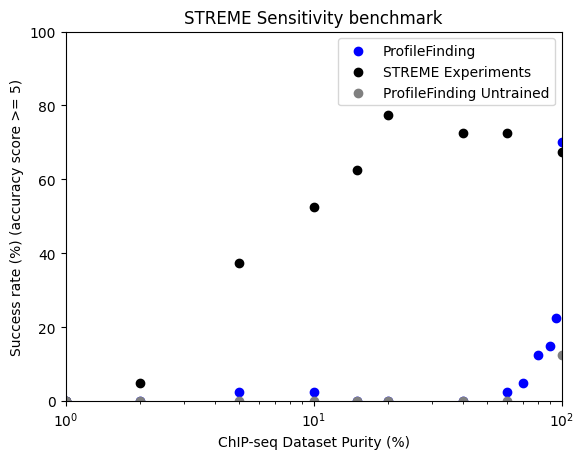

In [8]:
fig, ax = plt.subplots(1,1)
ax.scatter(x=results_diluted['model']['purity'],
           y=results_diluted['model']['success_rate'],
           marker="o",
           color="blue")
ax.scatter(x=results_diluted['streme']['purity'],
           y=results_diluted['streme']['success_rate'],
           marker="o",
           color="black")
ax.scatter(x=results_diluted['model_init']['purity'],
           y=results_diluted['model_init']['success_rate'],
           marker="o",
           color="grey")
ax.set_xlabel("ChIP-seq Dataset Purity (%)")
ax.set_ylabel("Success rate (%) (accuracy score >= 5)")
ax.set_xscale("log")
ax.set_xlim(1, 100)
ax.set_ylim(0, 100)
ax.set_title("STREME Sensitivity benchmark")
# add a legend in the plot
ax.legend(["ProfileFinding", "STREME Experiments", "ProfileFinding Untrained"])
plt.show()

In [10]:
print(f"                   x: {results_diluted['model']['purity'][-1]}")
print(f"STREME experiments y: {results_diluted['streme']['success_rate'][-1]}")
print(f"ProfileFinding     y: {results_diluted['model']['success_rate'][-1]}")

                   x: 100
STREME experiments y: 67.5
ProfileFinding     y: 70.0


In [19]:
import os
for dil in sorted((wd_model / "diluted" ).iterdir()):
    if not dil.is_dir() or dil.name == "logs":
        continue
    
    #print(f"{dil.name=}")
    nmotifs = 0
    for file in ref_full["file"]:
        p = dil / file
        assert p.exists(), f"{p} does not exist"
        if not (p / "tomtom").exists():
            print(f"[WARNING] >>> {p / 'tomtom'} does not exist")
            continue

        resultfile = p / "tomtom/tomtom.tsv"
        assert resultfile.exists(), f"{resultfile} does not exist"

        #print(f"[DEBUG] >>> [{mdl=}] {resultfile}")
        result = pd.read_csv(resultfile, sep="\t", comment="#")
        if len(result.index) > 0:
            nmotifs += 1
        # if len(result.index) == 0:
        #     print(f"{dil.name=} {file=} {resultfile} has no results")
        # else:
        #     # run make_tomtom.doc
        #     assert (p / "make_tomtom.doc").exists(), f"{p / 'make_tomtom.doc'} does not exist"
        #     os.system(f"bash {str(p)}/make_tomtom.doc")

    print(f"{dil.name} % data set purity: {nmotifs=}/{len(ref_full.index)}")

0.01 % data set purity: nmotifs=20/40
0.02 % data set purity: nmotifs=20/40
0.05 % data set purity: nmotifs=21/40
0.10 % data set purity: nmotifs=20/40
0.15 % data set purity: nmotifs=18/40
0.20 % data set purity: nmotifs=23/40
0.40 % data set purity: nmotifs=22/40
0.60 % data set purity: nmotifs=22/40
1.00 % data set purity: nmotifs=39/40


Thoroughness

In [13]:
results_hybrid = {
    'streme': {
        'pp_thresh': list(range(3,11)),
        'avg_success_rate': [],
        'std_success_rate': [],
    },
    'model': {
        'pp_thresh': list(range(3,11)),
        'avg_success_rate': [],
        'std_success_rate': [],
    },
    'model_init': {
        'pp_thresh': list(range(3,11)),
        'avg_success_rate': [],
        'std_success_rate': [],
    }
}

for wd, mdl in [(wd_streme, "streme"), (wd_model, "model"), (wd_model_init, "model_init")]:
    iterations = sorted([d.name for d in (wd / 'hybrid').iterdir() if d.is_dir()])
    print(f"{iterations=}")

    for pp_t in results_hybrid[mdl]['pp_thresh']:
        rates = []
        for it in iterations:
            ny = 0
            for file in ref_hyb["file"]:
                p = wd / "hybrid" / it / file
                assert p.exists(), f"{p} does not exist"
                assert (p / "tomtom").exists(), f"{p / 'tomtom'} does not exist"
                resultfile = p / "tomtom/tomtom.tsv"
                assert resultfile.exists(), f"{resultfile} does not exist"

                result = pd.read_csv(resultfile, sep="\t", comment="#")
                pval = result["p-value"].min()
                # negative log10 of p-value
                ppval = -math.log10(pval)
                if ppval >= pp_t:
                    ny += 1

            rates.append(ny*100/len(ref_hyb.index))

        results_hybrid[mdl]['avg_success_rate'].append(sum(rates)/len(rates))
        results_hybrid[mdl]['std_success_rate'].append(math.sqrt(sum([(r - results_hybrid[mdl]['avg_success_rate'][-1])**2 for r in rates])/len(rates)))

iterations=['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
iterations=['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
iterations=['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']


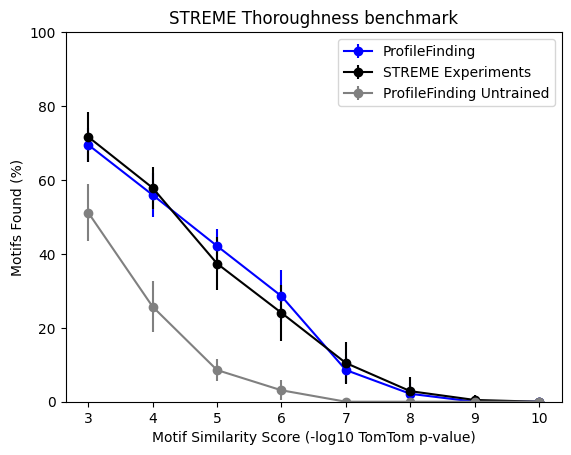

In [14]:
fig, ax = plt.subplots(1,1)
ax.errorbar(x=results_hybrid['model']['pp_thresh'],
           y=results_hybrid['model']['avg_success_rate'],
           marker="o",
           yerr=results_hybrid['model']['std_success_rate'],
           color="blue")
ax.errorbar(x=results_hybrid['streme']['pp_thresh'],
           y=results_hybrid['streme']['avg_success_rate'],
           marker="o",
           yerr=results_hybrid['streme']['std_success_rate'],
           color="black")
ax.errorbar(x=results_hybrid['model_init']['pp_thresh'],
            y=results_hybrid['model_init']['avg_success_rate'],
            marker="o",
            yerr=results_hybrid['model_init']['std_success_rate'],
            color="grey")
ax.set_xlabel("Motif Similarity Score (-log10 TomTom p-value)")
ax.set_ylabel("Motifs Found (%)")
ax.set_ylim(0, 100)
ax.set_title("STREME Thoroughness benchmark")
# add a legend in the plot
ax.legend(["ProfileFinding", "STREME Experiments", "ProfileFinding Untrained"])
plt.show()

---

Evaluate deviation of multiple STREME and ProfileFinding runs on the same data

In [15]:
wd_streme_std = Path("/home/ebelm/genomegraph/runs/20240903_replicate_STREME_results/full_repeat")
wd_model_std = Path("/home/ebelm/genomegraph/runs/20241008_model_on_STREME_data/full_repeat")

In [20]:
results_full_std = {
    'streme': {
        'pp_thresh': list(range(3,11)),
        'avg_success_rate': [],
        'std_success_rate': [],
        'max_success_rate': [],
        'min_success_rate': [],
    },
    'model': {
        'pp_thresh': list(range(3,11)),
        'avg_success_rate': [],
        'std_success_rate': [],
        'max_success_rate': [],
        'min_success_rate': [],
    },
}

for wd, mdl in [(wd_streme_std, "streme"), (wd_model_std, "model")]:
    iterations = sorted([d.name for d in wd.iterdir() if d.is_dir() and d.name != "logs"])
    print(f"{iterations=}")

    for pp_t in results_full_std[mdl]['pp_thresh']:
        rates = []
        for it in iterations:
            ny = 0
            for file in ref_full["file"]:
                p = wd / it / file
                assert p.exists(), f"{p} does not exist"
                assert (p / "tomtom").exists(), f"{p / 'tomtom'} does not exist"
                resultfile = p / "tomtom/tomtom.tsv"
                assert resultfile.exists(), f"{resultfile} does not exist"

                result = pd.read_csv(resultfile, sep="\t", comment="#")
                pval = result["p-value"].min()
                # negative log10 of p-value
                ppval = -math.log10(pval)
                if ppval >= pp_t:
                    ny += 1

            rates.append(ny*100/len(ref_full.index))

        results_full_std[mdl]['avg_success_rate'].append(statistics.mean(rates))
        results_full_std[mdl]['std_success_rate'].append(statistics.stdev(rates))
        results_full_std[mdl]['max_success_rate'].append(max(rates))
        results_full_std[mdl]['min_success_rate'].append(min(rates))
        

        

iterations=['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '3', '4', '5', '6', '7', '8', '9']
iterations=['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '3', '4', '5', '6', '7', '8', '9']


In [28]:
results_full_std

{'streme': {'pp_thresh': [3, 4, 5, 6, 7, 8, 9, 10],
  'avg_success_rate': [93.21428571428571,
   89.76190476190476,
   75.11904761904762,
   60.833333333333336,
   39.523809523809526,
   17.023809523809526,
   6.904761904761905,
   2.142857142857143],
  'std_success_rate': [1.1572751247156894,
   2.7277236279499046,
   2.4336431635757627,
   2.993047499344662,
   3.4112907765103757,
   2.5762190826683904,
   2.222718198619922,
   1.8175729499999247],
  'max_success_rate': [95.0, 95.0, 80.0, 65.0, 47.5, 25.0, 10.0, 5.0],
  'min_success_rate': [92.5, 85.0, 70.0, 55.0, 35.0, 15.0, 2.5, 0.0]},
 'model': {'pp_thresh': [3, 4, 5, 6, 7, 8, 9, 10],
  'avg_success_rate': [95.0, 90.0, 70.0, 55.0, 37.5, 20.0, 10.0, 0.0],
  'std_success_rate': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  'max_success_rate': [95.0, 90.0, 70.0, 55.0, 37.5, 20.0, 10.0, 0.0],
  'min_success_rate': [95.0, 90.0, 70.0, 55.0, 37.5, 20.0, 10.0, 0.0]}}

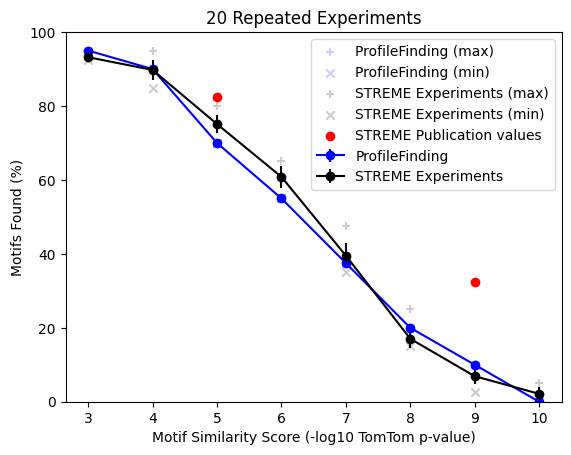

In [27]:
fig, ax = plt.subplots(1,1)
ax.errorbar(x=results_full_std['model']['pp_thresh'],
            y=results_full_std['model']['avg_success_rate'],
            marker="o",
            yerr=results_full_std['model']['std_success_rate'],
            color="blue")
ax.scatter(x=results_full_std['model']['pp_thresh'],
           y=results_full_std['model']['max_success_rate'],
           marker="+",
           color=(0,0,1,0.2))
ax.scatter(x=results_full_std['model']['pp_thresh'],
           y=results_full_std['model']['min_success_rate'],
           marker="x",
           color=(0,0,1,0.2))
ax.errorbar(x=results_full_std['streme']['pp_thresh'],
            y=results_full_std['streme']['avg_success_rate'],
            marker="o",
            yerr=results_full_std['streme']['std_success_rate'],
            color="black")
ax.scatter(x=results_full_std['streme']['pp_thresh'],
           y=results_full_std['streme']['max_success_rate'],
           marker="+",
           color=(0,0,0,0.2))
ax.scatter(x=results_full_std['streme']['pp_thresh'],
           y=results_full_std['streme']['min_success_rate'],
           marker="x",
           color=(0,0,0,0.2))
ax.scatter(x=[5, 9],
           y=[82.5, 32.5],
           marker="o",
           color="red")

ax.set_xlabel("Motif Similarity Score (-log10 TomTom p-value)")
ax.set_ylabel("Motifs Found (%)")
ax.set_ylim(0, 100)
ax.set_title("20 Repeated Experiments")
# add a legend in the plot
ax.legend(["ProfileFinding (max)", "ProfileFinding (min)", "STREME Experiments (max)", "STREME Experiments (min)", "STREME Publication values", "ProfileFinding", "STREME Experiments"])
plt.show()